In [1]:
%load_ext autoreload
%autoreload 2

import time
import torch
import kornia
import cv2
import copy
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np
from tqdm import tqdm
import wandb
from torch_openpose.body import Body
from torch_openpose import util


import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')


from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f, LogLevel


In [2]:
def wandb_init(name):
    run = wandb.init(
        project = "mts_texture_test", 
        reinit = True,
        name = name,
        config={
            "steps": 100,
            "learning_rate": 0.2,
            "optimizer": "Adam",
            "noise_width": 200,
            "noise_height": 400,
        }
    )
    
    return run 

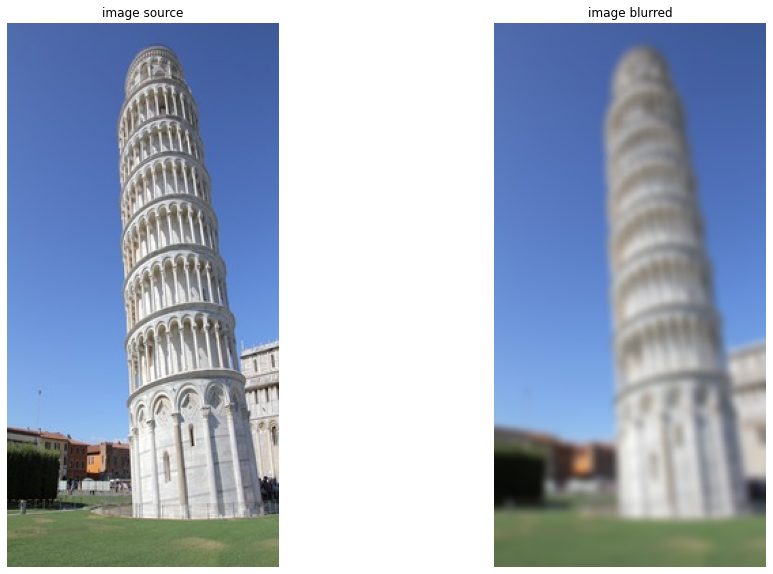

In [3]:
device = torch.device("cuda:0")
origal_file_name = 'pose_scene/pisa.jpg'
img = cv2.imread(origal_file_name)[..., (2,1,0)]

gauss = kornia.filters.GaussianBlur2d((11, 11), (3, 3))

data = kornia.image_to_tensor(img, keepdim=False)

x_blur: torch.tensor = gauss(data.float())
    
# convert back to numpy
img_blur: np.ndarray = kornia.tensor_to_image(x_blur.byte())

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(img)

axs[1].axis('off')
axs[1].set_title('image blurred')
axs[1].imshow(img_blur)

In [4]:
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
origal_file_name = 'pose_scene/pisa.jpg'
origal_texture = cv2.imread(origal_file_name)[..., (2,1,0)]
diff_parameter = 'rect.bsdf.reflectance.data'

SPP = 8
noise_resolution  = np.array([200, 400])

device = torch.device("cuda:0")
thread = Thread.thread()
thread.file_resolver().append('pose_scene')
logger = thread.logger()
logger.set_log_level(LogLevel.Warn)

scene = load_file('pose_scene/scene_image_texture.xml')
params = traverse(scene)


params.keep([diff_parameter])
params[diff_parameter] = origal_texture.flatten() / 255
params.update()
params_torch = params.torch()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 431.5, 367.5, -0.5)

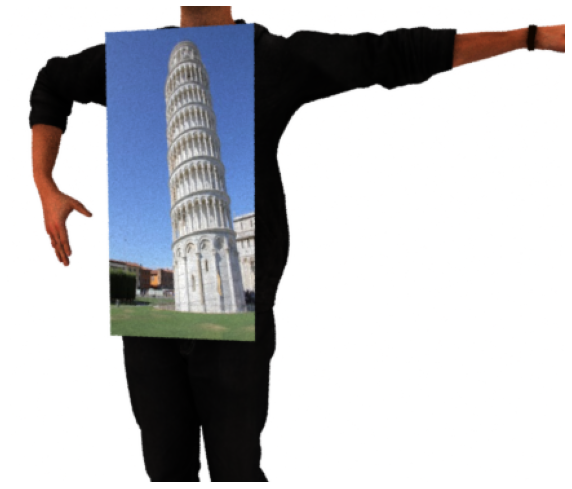

In [5]:
# Render a reference image (no derivatives used yet)
rendering_torch_ref = render_torch(scene, params=params, unbiased=False, malloc_trim=True,  spp=SPP)

canvas = rendering_torch_ref.cpu().detach().numpy() 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(canvas)
ax.axis('off')

In [23]:
run = wandb_init(origal_file_name)
noise_resolution  = np.array([200, 400])


diff_parameter = 'rect.bsdf.reflectance.data'
params.keep([diff_parameter])
params[diff_parameter] = [0] * len(params[diff_parameter])
params.update()
# Which parameters should be exposed to the PyTorch optimizer?
params_torch = params.torch()


# set up optimizer
opt = torch.optim.Adam(params_torch.values(), lr=run.config.learning_rate)
objective = torch.nn.MSELoss()
blur_loss = 'l1'
if blur_loss == 'SSIM':
    REGULARIZATION = torch.tensor(1e-2, device=device)
    objective_blur = kornia.losses.SSIM(5, reduction='mean')
else:
    REGULARIZATION = torch.tensor(2.5, device=device)
    objective_blur = torch.nn.MSELoss()
gauss = kornia.filters.GaussianBlur2d((11, 11), (3, 3))

for step in tqdm(range(run.config.steps)):
    if step % 50 ==  0:
        write_bitmap('output/image_texture_%03i.png' % step, params_torch[diff_parameter], noise_resolution)
    opt.zero_grad()

    # render image
    # maybe add malloc_trim=True if memory issues
    cur_rednering_torch = render_torch(scene, params=params, unbiased=False, malloc_trim=True, spp=SPP, **params_torch)
    
    ob_val_heat = objective(rendering_torch_ref, cur_rednering_torch)
    y = params_torch[diff_parameter].view(noise_resolution[1], noise_resolution[0], 3)
    y = torch.stack([y.permute((2, 0, 1))])
    y_blur = gauss(y)
    ob_smooth = objective_blur(y, y_blur)
    
    ob_val = ob_val_heat + REGULARIZATION  * ob_smooth
    
    # calc gradient
    ob_val.backward()
    
    # take a step in gradient direction
    opt.step()
    
    # log the loss
    wandb.log({'loss': ob_val.item()}, step=step)

wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original')

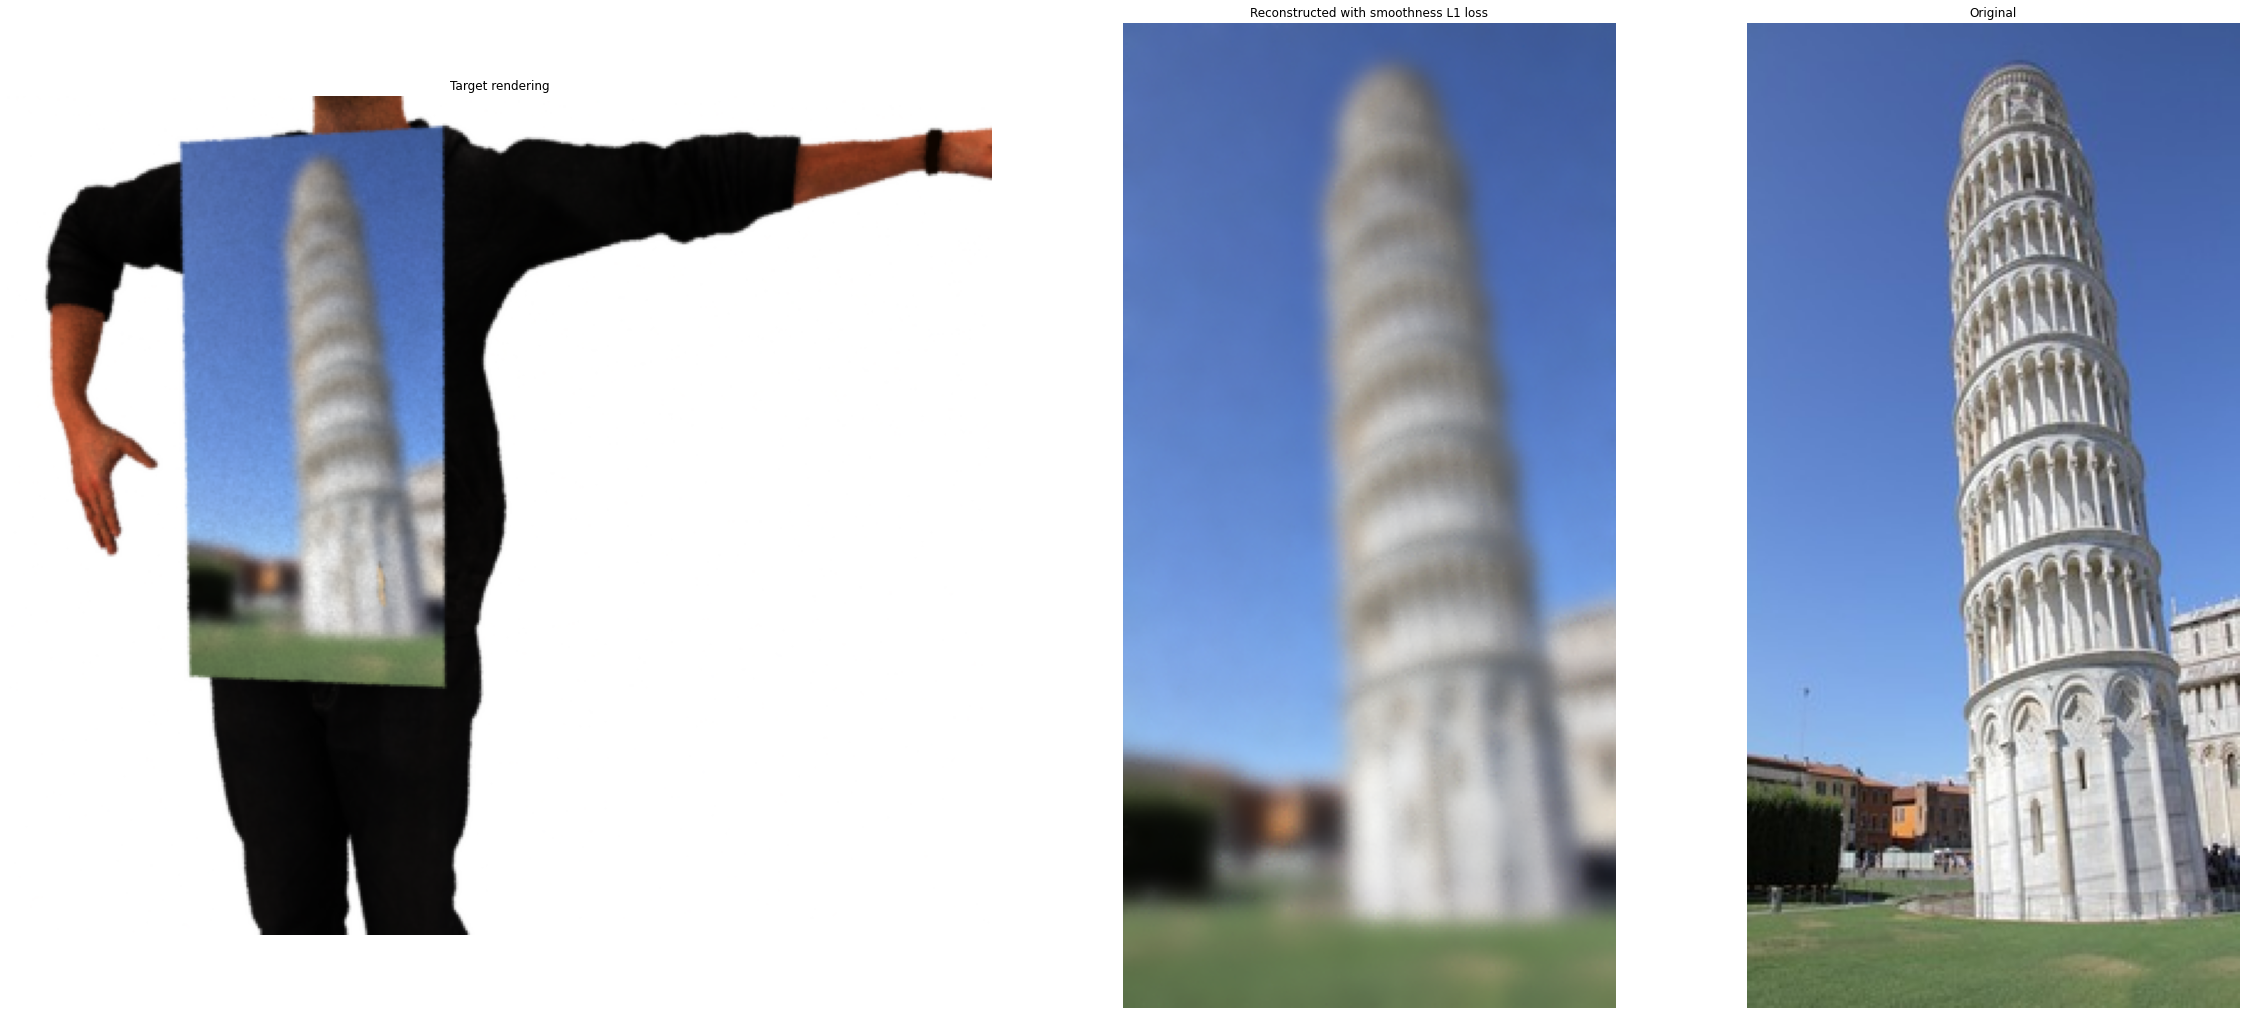

In [24]:
canvas = params_torch[diff_parameter].detach().cpu().numpy()
canvas = canvas.reshape(noise_resolution[1], noise_resolution[0], -1)


rendering_canvas = cur_rednering_torch.cpu().detach().numpy() 

fig = plt.figure(figsize=(40, 80))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])

ax = plt.subplot(gs[0])
ax.imshow(rendering_canvas)
ax.axis('off')
ax.set_title('Target rendering')

ax = plt.subplot(gs[1])
ax.imshow(canvas)
ax.axis('off')
ax.set_title('Reconstructed with smoothness L1 loss')

ax = plt.subplot(gs[2])
ax.imshow(origal_texture)
ax.axis('off')
ax.set_title('Original')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original')

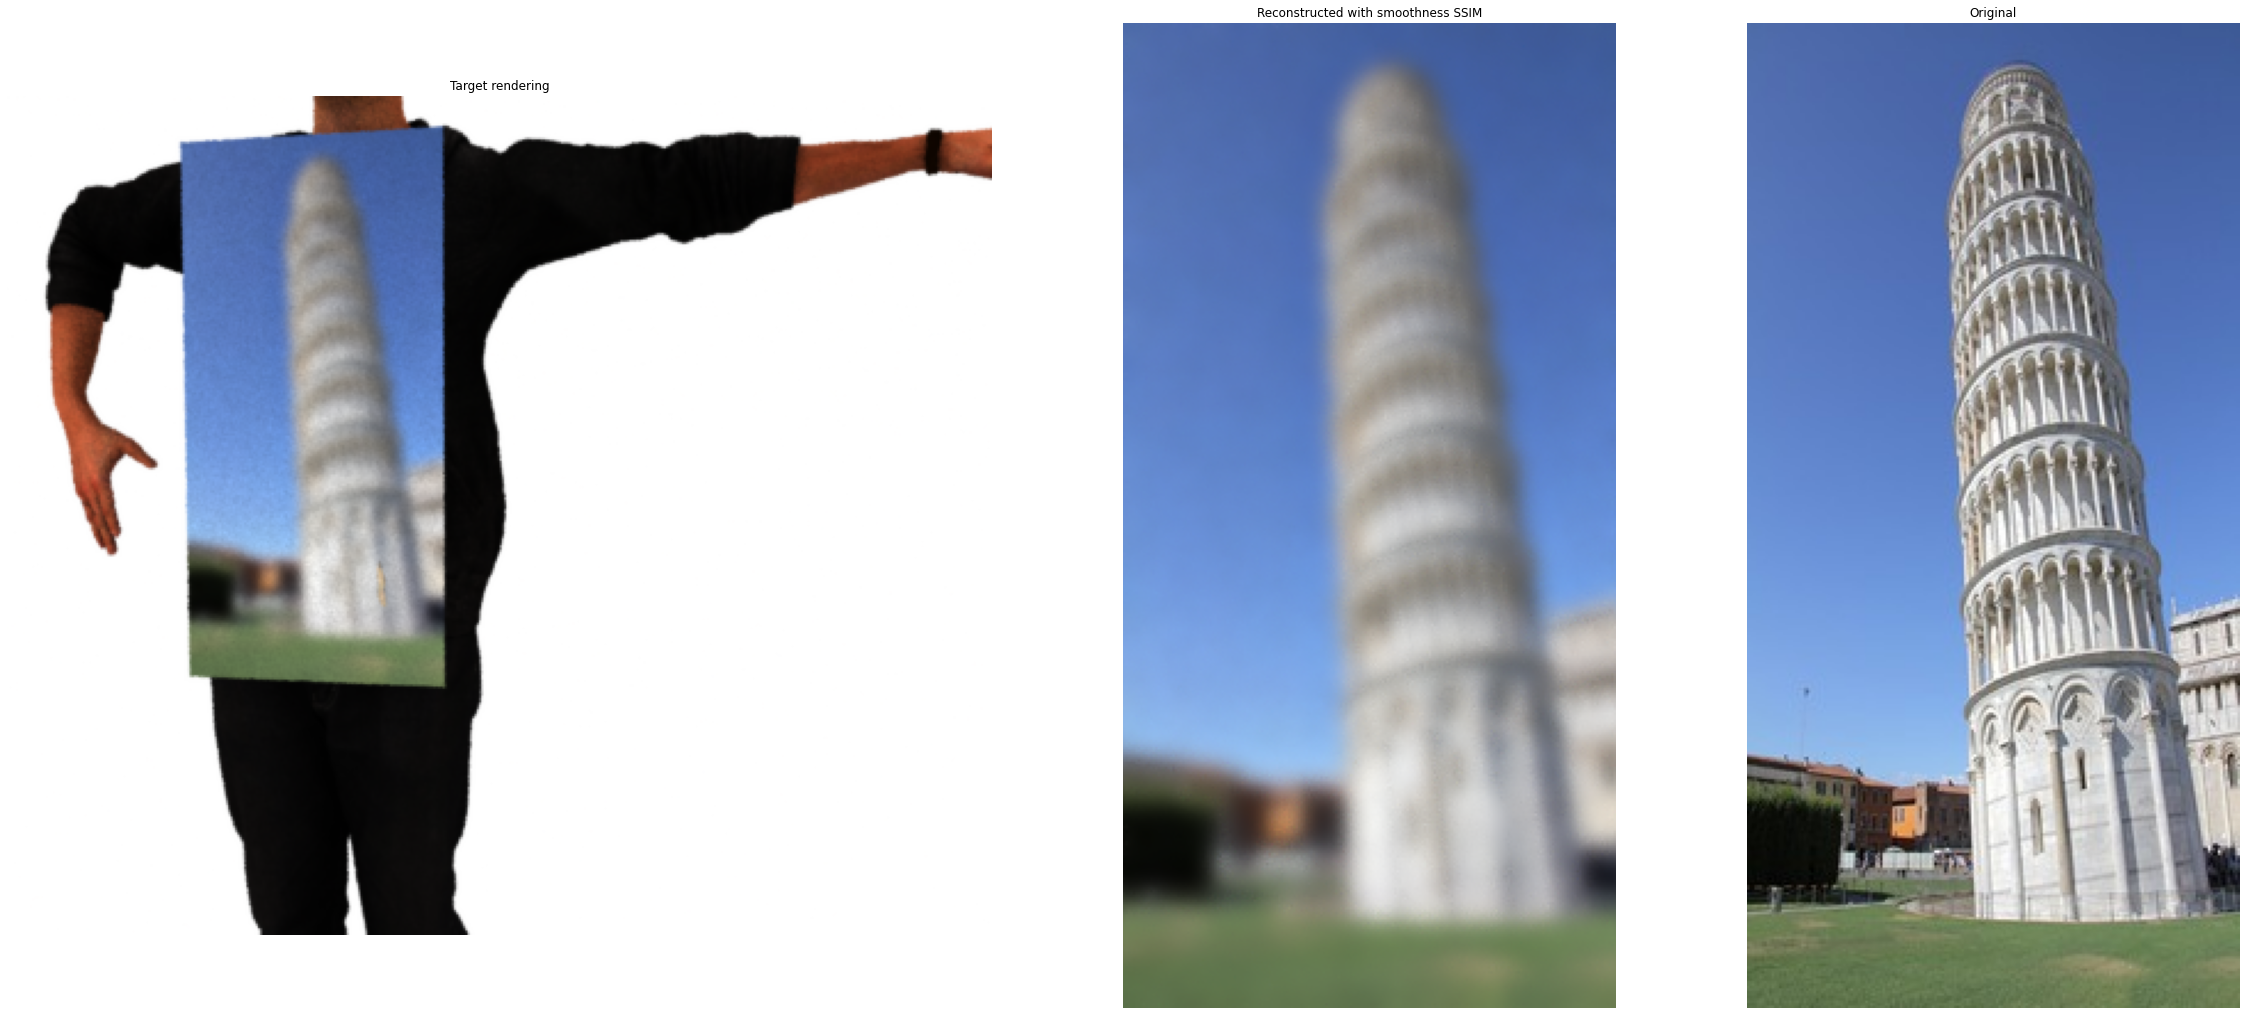

In [25]:
canvas = params_torch[diff_parameter].detach().cpu().numpy()
canvas = canvas.reshape(noise_resolution[1], noise_resolution[0], -1)


rendering_canvas = cur_rednering_torch.cpu().detach().numpy() 

fig = plt.figure(figsize=(40, 80))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])

ax = plt.subplot(gs[0])
ax.imshow(rendering_canvas)
ax.axis('off')
ax.set_title('Target rendering')

ax = plt.subplot(gs[1])
ax.imshow(canvas)
ax.axis('off')
ax.set_title('Reconstructed with smoothness SSIM')

ax = plt.subplot(gs[2])
ax.imshow(origal_texture)
ax.axis('off')
ax.set_title('Original')